In [17]:
print("Versions of the runtime and packages used for this assignment:")
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import skfuzzy as fuzz
print("scikit-fuzzy version: {}".format(fuzz.__version__))

print("-------------------------------------------------------")
print("When run on my machine the following versions were used:")
print("Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]")
print("pandas version: 2.1.2")
print("matplotlib version: 3.9.2")
print("NumPy version: 1.24.3")
print("scikit-fuzzy version: 0.5.0")

Versions of the runtime and packages used for this assignment:
Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.2.3
matplotlib version: 3.10.1
NumPy version: 2.2.3
scikit-fuzzy version: 0.5.0
-------------------------------------------------------
When run on my machine the following versions were used:
Python version: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.1.2
matplotlib version: 3.9.2
NumPy version: 1.24.3
scikit-fuzzy version: 0.5.0


### Define domain of input variables

In [18]:
# import libraries
from skfuzzy import control as ctrl

# Each input variable has an associated universe of discourse which represents the range of values that the variable can take on
# Define the universe of discourse for each input variable

# Given the minimum and maximum values for a given domain
# create a range of values that includes all integers less than or equal to the maximum value and greater than or equal to the minimum value
def create_range(minimum_value, maximum_value):
    increment_by_one = 1
    return np.arange(minimum_value, maximum_value + 1, increment_by_one)

zero_parts_per_million = 0
five_thousand_parts_per_million = 5000
soil_level_universe = create_range(
    minimum_value=zero_parts_per_million,
    maximum_value=five_thousand_parts_per_million
)

zero_pounds = 0
twenty_pounds = 20
load_size_universe = create_range(
    minimum_value=zero_pounds,
    maximum_value=twenty_pounds
)

zero_degrees_celcius = 0
one_hundred_degrees_celcius = 100
temperature_universe = create_range(
    minimum_value=zero_degrees_celcius,
    maximum_value=one_hundred_degrees_celcius
)

### Define fuzzy antecedants

In [19]:
# Define the antecedents for each input variable that represent the fuzzy conditions that must be satisfied for a rule in the system to be applied
# Unlike conditions in traditional logic, fuzzy conditions can be partially satisfied
# Instead of "if the soil level is high" we can say "if the soil level is somewhat high"
soil_level = ctrl.Antecedent(soil_level_universe, 'soil_level')
load_size = ctrl.Antecedent(load_size_universe, 'load_size')
water_temperature = ctrl.Antecedent(temperature_universe, 'water_temperature')

### Define the consequent

In [20]:
# Define the universe of discourse for the output variable
one_minute = 1
one_hundred_twenty_minutes = 120
wash_time_universe = create_range(
    minimum_value=one_minute,
    maximum_value=one_hundred_twenty_minutes
)

# Define the consequent that represents the calculation of the output wash time
# The output is calculated when the antecedents are satisfied
wash_time = ctrl.Consequent(wash_time_universe, 'wash_time')

### Define the fuzzy sets

In [21]:
# Define fuzzy sets for each input variable
# Represents categories that don't have precise boundaries
# Unlike traditional sets, fuzzy sets can have elements with partial membership represented by a value between 0 and 1
# For example, a temperature of 30 degrees celcius might be 0.8 in the "cold" set, 0.2 in the "warm" set, and 0 in the "hot" set
soil_level_categories = ['light', 'medium', 'heavy']
load_size_categories = ['small', 'medium', 'large']
temperature_categories = ['cold', 'warm', 'hot']

### Membership functions for antecedents

In [22]:
# Define membership functions for the antecedents
# Used to fuzzify the input and relate precise values to degrees of membership in fuzzy sets

# Define a guassian membership function for each of the load size fuzzy sets
# The shape of the membership function is defined by the mean and standard deviation
# This shape is ideal because there are no sharp boundaries between the categories despite the fact that the categories are distinct
# The mean is the center of the distribution and the standard deviation is the spread of the distribution

ten_pounds = 10

load_size['small'] = fuzz.gaussmf(load_size.universe, mean=zero_pounds, sigma=2)
load_size['medium'] = fuzz.gaussmf(load_size.universe, mean=ten_pounds, sigma=2)
load_size['large'] = fuzz.gaussmf(load_size.universe, mean=twenty_pounds, sigma=2)


# Define a left-shoulder membership function for the cold water temperatures
# Specific type of trapaizoidal membership function that has a plateau at the start of the range and a decrease in membership as the value increases
# There are a range of values with the same membership, called a plateau, and a gradual decrease in membership as the value increases past the end of the plateau
# In other words anything colder than thirty degrees celcius is considered cold despite a difference in temperature

thirty_degrees_celcius = 30
forty_degrees_celcius = 40
fifty_degrees_celcius = 50
sixty_degrees_celcius = 60
seventy_degrees_celcius = 70

# Smallest value in the universe of discourse
water_temperature_range_start = zero_degrees_celcius
# The plateau is the range of values that all have a membership of 1
cold_water_plateau_end = thirty_degrees_celcius
# The slope of a left shoulder shape is the range of values after the plateau where the membership decreases from 1 to 0 gradually
cold_water_slope_end = forty_degrees_celcius
water_temperature['cold'] = fuzz.trapmf(water_temperature.universe, [
    water_temperature_range_start,
    water_temperature_range_start,
    cold_water_plateau_end,
    cold_water_slope_end
])

# Define a triangular membership function for the warm water temperatures
# The shape of the membership function is defined by the three points: start, peak, and end
# It models the degree of membership for warm water because there is a single value with the strongest memberhsip, called a peak, and symmetric decrease in membership away from peak
# In other words fifty degrees celcius is clearly warm and gradually becomes considered cold as the temperature decreases and gradually becomes considered hot as the temperature increases

# The start is the lowest value with a membership of 0
warm_water_start = thirty_degrees_celcius
# The peak is the value with the highest membership
warm_water_peak = fifty_degrees_celcius
# The end is the highest value with a membership of 0
warm_water_end =  seventy_degrees_celcius
water_temperature['warm'] = fuzz.trimf(water_temperature.universe, [
    warm_water_start,
    warm_water_peak,
    warm_water_end
])

# Define a right-shoulder membership function for the hot water temperatures
# Specific type of trapaizoidal membership function that has a plateau at the end of the range and an descrease in membership as the value decreases
# There are a range of values with the same membership, called a plateau, and a decrease in membership as the value decreases past the start of the plateau
# In other words, Similar to cold water anything hotter than fifty degrees celcius is considered hot despite a difference in temperature

# The end is the highest value in the universe of discourse
water_temperature_range_end = one_hundred_degrees_celcius

# The plateau is the range of values that all have a membership of 1
hot_water_plateau_start = seventy_degrees_celcius
# The slope of a right shoulder shape is the range of values before the plateau where the membership increases from 0 to 1 gradually
hot_water_slope_start = sixty_degrees_celcius
water_temperature['hot'] = fuzz.trapmf(water_temperature.universe, [
    hot_water_slope_start,
    hot_water_plateau_start,
    water_temperature_range_end,
    water_temperature_range_end
])

# Define a triangular membership function for each of the soil level fuzzy sets
# There are specific input values that strongly represent memebership in a set.
# This was also choosen for simplicity
soil_level.automf(names=soil_level_categories)

### Visualize antecendent membership functions

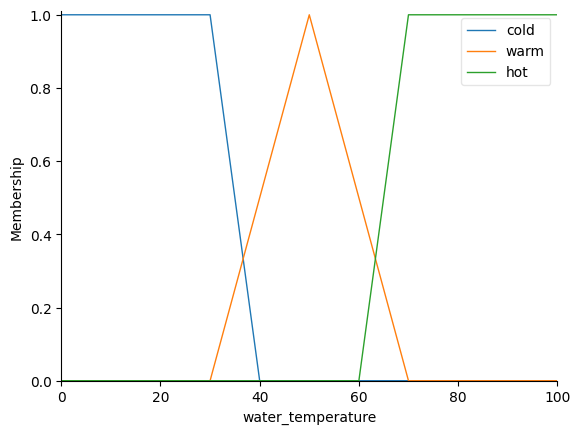

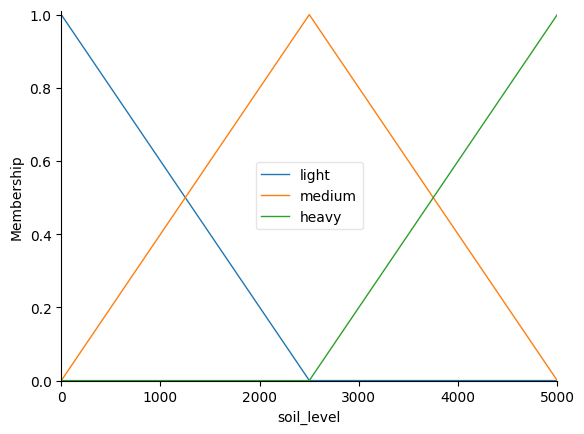

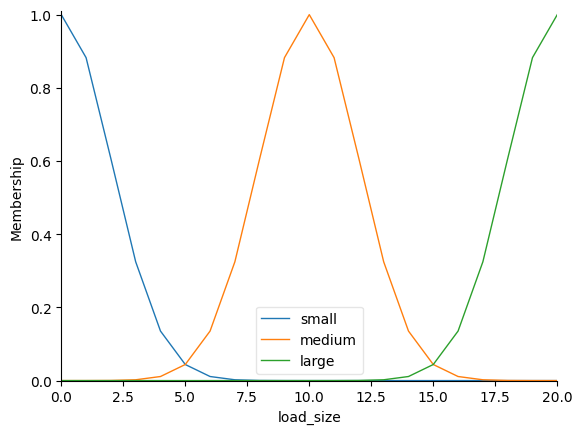

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="skfuzzy.control.fuzzyvariable")


# Visualize the membership functions
water_temperature.view()
soil_level.view()
load_size.view()


### Membership functions for consequent

In [24]:
# Define membership functions for the consequent.
# Represents how the output variable relates to a degree of membership in a fuzzy set.
# Unlike, membership functions for antecedents,
#  this membership function is used to defuzzify the output to output a percise wash time

# A Left-Right-Shoulder membership function will be used where the plateau extends on the right side indefinitely and to left indefinitely
# This should model the perception that anything greater than X minutes is preceived as long and increases in duration past X don't signficantly change the perception.
# Similarly, anything less than Y minutes is perceived as short and decreases in duration past Y don't significantly change the perception.

zero_minutes = 0
minimum_wash_time = zero_minutes
maximum_wash_time = one_hundred_twenty_minutes
short_duration_threshold = 30
short_duration_slope_end = 40
long_duration_threshold = 60
long_duration_slope_start = 50

# Define a left-should trapezodal membership funciton
# Any wash time shorter than 30 minutes is considered short despite changes in duration
wash_time['short'] = fuzz.trapmf(wash_time.universe, [
    minimum_wash_time,
    minimum_wash_time,
    short_duration_threshold,
    short_duration_slope_end
])
# Define a right-should trapezodal membership funciton
# Any wash time longer than 60 minutes is considered long despite changes in duration
wash_time['long'] = fuzz.trapmf(wash_time.universe, [
    long_duration_slope_start,
    long_duration_threshold,
    maximum_wash_time,
    maximum_wash_time
])

# Medium wash time has a trapezoidal membership function
# This models the perception that a medium wash time is between a short and long wash time with some range of wash times that are all equally considered a medium wash time
medium_duration_slope_start = 25
medium_duration_slope_end = 65
wash_time['medium'] = fuzz.trapmf(wash_time.universe, [
    medium_duration_slope_start,
    short_duration_threshold,
    long_duration_threshold,
    medium_duration_slope_end,
])

### Visualize consequent membership function

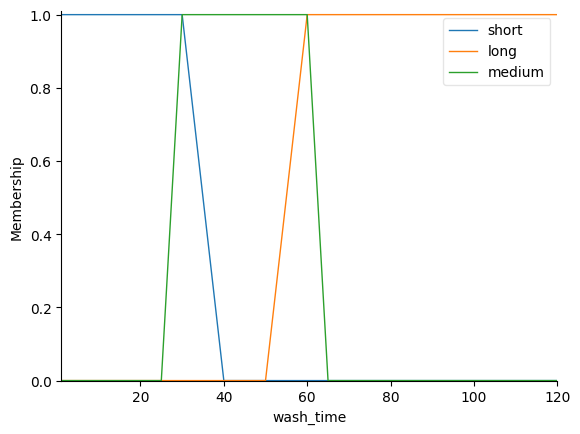

In [25]:
wash_time.view()

### Define the rules for the controller

In [26]:
# Create a dictionary to map wash cycle descriptions to wash time categories
# This will be used to generate rules for the fuzzy logic controller
wash_time_category_by_wash_cycle_description = {
    ('light', 'small', 'cold'): 'short',
    ('light', 'small', 'warm'): 'short',
    ('light', 'small', 'hot'): 'short',
    ('light', 'medium', 'cold'): 'medium',
    ('light', 'medium', 'warm'): 'medium',
    ('light', 'medium', 'hot'): 'short',
    ('light', 'large', 'cold'): 'long',
    ('light', 'large', 'warm'): 'medium',
    ('light', 'large', 'hot'): 'short',
    ('medium', 'small', 'cold'): 'medium',
    ('medium', 'small', 'warm'): 'medium',
    ('medium', 'small', 'hot'): 'short',
    ('medium', 'medium', 'cold'): 'long',
    ('medium', 'medium', 'warm'): 'medium',
    ('medium', 'medium', 'hot'): 'medium',
    ('medium', 'large', 'cold'): 'long',
    ('medium', 'large', 'warm'): 'long',
    ('medium', 'large', 'hot'): 'medium',
    ('heavy', 'small', 'cold'): 'long',
    ('heavy', 'small', 'warm'): 'medium',
    ('heavy', 'small', 'hot'): 'medium',
    ('heavy', 'medium', 'cold'): 'long',
    ('heavy', 'medium', 'warm'): 'long',
    ('heavy', 'medium', 'hot'): 'medium',
    ('heavy', 'large', 'cold'): 'long',
    ('heavy', 'large', 'warm'): 'long',
    ('heavy', 'large', 'hot'): 'medium'
}

# Given a wash cycle description, generate a rule for the fuzzy logic controller
# The conditions of the rule will determined by the fuzzy sets of the input variables
# The consequent of the rule will be the target wash time
def generate_rule_for(wash_cycle_description):
    soil_level_category, load_size_category, water_temperature_category = wash_cycle_description
    wash_cycle_conditions = (
        soil_level[soil_level_category] &
        load_size[load_size_category] &
        water_temperature[water_temperature_category]
    )
    wash_time_category = wash_time_category_by_wash_cycle_description[wash_cycle_description]
    target_wash_time = wash_time[wash_time_category]
    return ctrl.Rule(wash_cycle_conditions, target_wash_time)

# Generate rules for all possible wash cycle descriptions
rules = [
    generate_rule_for(wash_cycle_description)
    for wash_cycle_description
    in wash_time_category_by_wash_cycle_description
]


In [27]:
# Create a control system and simulation using Mamdani inference
model = ctrl.ControlSystem(rules)
washing_simulation = ctrl.ControlSystemSimulation(model)

In [28]:
# Given the precise input values for soil level, load size, and water temperature, return the wash time
def simulate_wash_time_with_precise_input(
        soil_level_value,
        load_size_value,
        water_temperature_value,
    ):
    # Provide inputs to the ControlSystem using Antecedent labels
    washing_simulation.input['soil_level'] = soil_level_value
    washing_simulation.input['load_size'] = load_size_value
    washing_simulation.input['water_temperature'] = water_temperature_value
    # Compute the output using the ControlSystem
    # Applies centroid defuzzification to convert the fuzzy output to a precise value
    washing_simulation.compute()
    # Return the computed wash time
    return washing_simulation.output['wash_time']

# Given a precise wash time, return the fuzzy set with the highest membership value
# This represents the category of wash time that the precise wash time is most likely to belong to
def get_fuzzy_set_with_highest_membership_value(precise_wash_time):
    # Compute the membership value of the precise wash time in each fuzzy set
    membership_values = {
        'short': fuzz.interp_membership(wash_time.universe, wash_time['short'].mf, precise_wash_time),
        'medium': fuzz.interp_membership(wash_time.universe, wash_time['medium'].mf, precise_wash_time),
        'long': fuzz.interp_membership(wash_time.universe, wash_time['long'].mf, precise_wash_time)
    }
    # Select the name of the fuzzy set with the highest membership value
    fuzzy_set_with_highest_membership_value = max(membership_values, key=membership_values.get)
    # Return the name of the fuzzy set with the highest membership value
    return fuzzy_set_with_highest_membership_value

# Create a friendly description of the precise wash time and the fuzzy set it most strongly belongs to
def build_wash_time_description(precise_wash_time):
    fuzzy_set = get_fuzzy_set_with_highest_membership_value(precise_wash_time)
    return f"{precise_wash_time:.2f} minute wash time, which is perceived to be a {fuzzy_set} wash time"


45.00 minute wash time, which is perceived to be a medium wash time


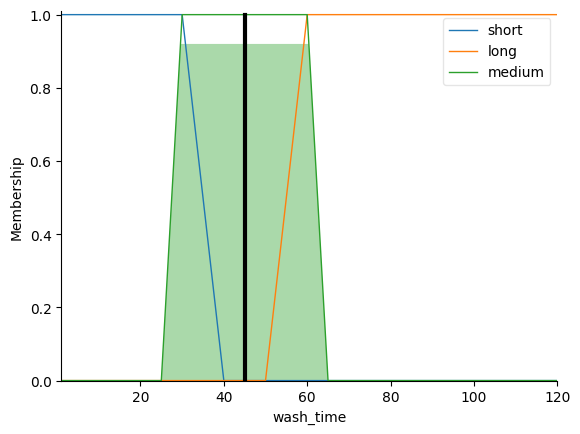

In [29]:
# Compute the wash time given the input values for soil level, load size, and water temperature
two_hundred_parts_per_million = 200
ten_kilograms = 10
fifty_degrees_celsius = 50
precise_wash_time = simulate_wash_time_with_precise_input(
    soil_level_value=two_hundred_parts_per_million,
    load_size_value=ten_kilograms,
    water_temperature_value=fifty_degrees_celsius
)
print(build_wash_time_description(precise_wash_time))
# Visualize the fuzzy set with the highest membership value for the precise wash time
wash_time.view(sim=washing_simulation)

### Simulate wash times with fuzzy inputs

87.44 minute wash time, which is perceived to be a long wash time


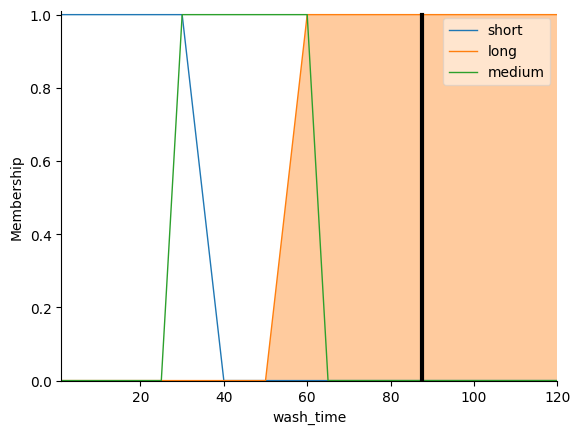

In [30]:
# Given the fuzzy sets of each input value return the wash time
def simulate_wash_time_with_fuzzy_input(
        soil_level_description,
        load_size_description,
        water_temperature_description
    ):
    # Dervice the precise input values from the fuzzy input sets
    precise_soil_level = soil_level.terms[soil_level_description]
    precise_load_size = load_size.terms[load_size_description]
    precise_water_temperature = water_temperature.terms[water_temperature_description]
    # Simulate the wash time with the precise input values
    return simulate_wash_time_with_precise_input(
        precise_soil_level,
        precise_load_size,
        precise_water_temperature
    )

# Compute the was time given the fuzzy input values for soil level, load size, and water temperature
precise_wash_time = simulate_wash_time_with_fuzzy_input(
    soil_level_description='heavy',
    load_size_description='large',
    water_temperature_description='cold'
)
print(build_wash_time_description(precise_wash_time))
wash_time.view(sim=washing_simulation)

In [31]:
input_values = [
    (500, 5, 20),
    (2500, 10, 50),
    (100, 18, 80),
    (5000, 20, 30),
    (2500, 1, 80)
]
print(f"{'Soil Level(ppm)':<16}{'Load Size(kg)':<16}{'Water Temp(℃)':<16}{'Wash Time(m)':<16}")
for soil_level, load_size, water_temperature in input_values:
    wash_time_value = simulate_wash_time_with_precise_input(
        soil_level_value=soil_level,
        load_size_value=load_size,
        water_temperature_value=water_temperature
    )
    print(f"{soil_level:<16}{load_size:<16}{water_temperature:<16}{wash_time_value:<16.0f}")

Soil Level(ppm) Load Size(kg)   Water Temp(℃)   Wash Time(m)    
500             5               20              60              
2500            10              50              45              
100             18              80              21              
5000            20              30              87              
2500            1               80              18              


Serialize the model and write it to disk. This will allow the model to be loaded in the web server

In [ ]:
import pickle

with open('../data/model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)